# 🧪 A new experiment from Jina AI

We're trying something new for blogs - instead of static posts, we're giving you interactive notebooks. Let us know your feedback in [Slack](https://slack.jina.ai)!

# Building a fashion search engine with `docarray`

[DocArray](https://docarray.jina.ai) is a library for nested, unstructured data in transit, including text, image, audio, video, 3D mesh, etc. It allows deep-learning engineers to efficiently process, embed, search, recommend, store, and transfer the data with a Pythonic API.

In this example we'll use DocArray to build a simple search engine for fashion images. You'll be able to upload an image of some clothing and find similar matches in the dataset.

In future notebooks we'll look at:

- Improving your model's performance using [Jina Finetuner](https://finetuner.jina.ai)
- Expanding and serving your search engine using [Jina's neural search framework](https://github.com/jina-ai/jina) and Executors from [Jina Hub](https://hub.jina.ai)

You can download this notebook from [GitHub](https://github.com/alexcg1/neural-search-notebooks). PRs and issues are always welcome!

## Watch the video

Get a guided tour of the notebook and search results with Jack from Jina AI

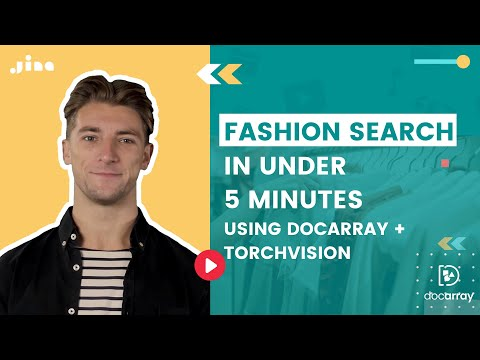

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("Amo19S1SrhE", width=800, height=450)

## Configuration

We'll set up some basic variables. Feel free to adapt these for your own project!

In [ ]:
DATA_DIR = "./data"
DATA_PATH = f"{DATA_DIR}/*.jpg"
MAX_DOCS = 1000
QUERY_IMAGE = "./query.jpg" # image we'll use to search with
PLOT_EMBEDDINGS = False # Really useful but have to manually stop it to progress to next cell

# Toy data - If data dir doesn't exist, we'll get data of ~800 fashion images from here
TOY_DATA_URL = "https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/data.zip?raw=true"

## Setup

In [ ]:
# We use "[full]" because we want to deal with more complex data like images (as opposed to text)
!pip install "docarray[full]==0.4.4"

In [ ]:
from docarray import Document, DocumentArray

## Load images

In [ ]:
# Download images if they don't exist
import os

if not os.path.isdir(DATA_DIR) and not os.path.islink(DATA_DIR):
    print(f"Can't find {DATA_DIR}. Downloading toy dataset")
    !wget "$TOY_DATA_URL" -O data.zip
    !unzip -q data.zip # Don't print out every darn filename
    !rm -f data.zip
else:
    print(f"Nothing to download. Using {DATA_DIR} for data")

In [ ]:
# Use `.from_files` to quickly load them into a `DocumentArray`
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)
print(f"{len(docs)} Documents in DocumentArray")

In [ ]:
docs.plot_image_sprites() # Preview the images

## Apply preprocessing

In [ ]:
from docarray import Document

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [ ]:
# apply en masse
docs.apply(preproc)

## Embed images

In [ ]:
!pip install torchvision==0.11.2

In [ ]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [ ]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50
model.fx = torch.nn.Identity() # remove the classification layer to work on the features

In [ ]:
docs.embed(model, device=device)

### Visualize embeddings

In [ ]:
if PLOT_EMBEDDINGS:
    docs.plot_embeddings(image_sprites=True, image_source="uri")

## Create query Document

Let's just use the first image from our dataset:

In [ ]:
# Download query doc
!wget https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/1_build_basic_search/query.jpg -O query.jpg

query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [ ]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [ ]:
# Apply same preprocessing
query_docs.apply(preproc)

In [ ]:
# ...and create embedding just like we did with the dataset
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

## Get matches

In [ ]:
query_docs.match(docs, limit=9)

## See the results

As you can see, the model is finding matches based on the input images - including the human wearing the clothes! In reality we want to match the clothes themselves, so later we'll fine-tune our model using Jina AI's [finetuner](https://finetuner.jina.ai).

In [ ]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()

In [ ]:
if PLOT_EMBEDDINGS:
    query_doc.matches.plot_embeddings(image_sprites=True, image_source="uri")

## Next steps

### Finetuning our model

In our next notebook we'll improve our model's performance with **[Jina Finetuner](https://finetuner.jina.ai)**

![](https://finetuner.jina.ai/_images/labeler-on-fashion-mnist.gif)

### Building into a real world application

In a future notebook we'll use **[Jina's neural search framework](https://github.com/jina-ai/jina/)** and **[Jina Hub Executors](https://hub.jina.ai)** to build a [real world fashion search engine](http://examples.jina.ai/fashion) with minimal lines of code.

![](https://github.com/alexcg1/jina-multimodal-fashion-search/raw/main/demo.gif)